In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
a = 0
b = 5

def f(x):
    return math.sqrt(x) + math.cos(x)

In [ ]:
def generate_intervals(knots, opt=False):

    if opt:
        x_opt_internal = []
        for i in range(knots - 2):
            x_i_opt = ((b - a) * math.cos((2 * i + 1) * math.pi / (2 * (knots - 2) + 2)) + b + a) / 2
            x_opt_internal.append(x_i_opt)
        
        x_opt_internal.insert(0, b)
        x_opt_internal.insert(knots - 1, a)
        y_opt_internal = []
        for x_i_opt in x_opt_internal:
            y_opt_internal.append(f(x_i_opt))
        return x_opt_internal[::-1], y_opt_internal[::-1]
    else:
        x_internal = np.linspace(a, b, knots)
        y_internal = []
        for x_i in x_internal:
            y_internal.append(f(x_i))
        return x_internal.tolist(), y_internal

In [ ]:
def spline_1_0_get_coef(x, y, knots):
    gamma = [y[0]]
    for i in range(1, knots - 1):
        gamma.append(y[i])
        gamma.append(y[i])
    gamma.append(y[knots - 1])

    H = np.zeros((2 * (knots - 1), 2 * (knots - 1)))

    j = 0
    for i in range(knots - 1):
        H[j][j] = x[i]
        H[j + 1][j] = x[i + 1]
        H[j][j + 1] = 1
        H[j + 1][j + 1] = 1
        j = j + 2

    coef = np.linalg.solve(H, gamma)
    return ({"x": x,
             "y": y,
             "coef": coef})
    

In [ ]:
def spline_1_0(coef, x_input):
    x = coef["x"]
    coef = coef["coef"]

    i = 0
    while(x_input > x[i + 1]):
        i = i + 1
    
    l_i = coef[2 * (i)] * x_input + coef[2 * (i) + 1]
    return l_i

In [ ]:
def spline_2_1_get_coef(x, y, knots):
    gamma = [y[0]]
    for i in range(1, knots - 1):
        gamma.append(y[i])
        gamma.append(y[i])
    gamma.append(y[knots - 1])

    for _ in range(knots - 1):
        gamma.append(0)
    H = np.zeros((3 * (knots - 1), 3 * (knots - 1)))
    j = 0
    i = 0
    k = 0
    while(k < knots - 1):
        H[i][j] = x[k]**2
        H[i][j + 1] = x[k]
        H[i][j + 2] = 1

        H[i + 1][j] = x[k + 1]**2
        H[i + 1][j + 1] = x[k + 1]
        H[i + 1][j + 2] = 1

        k = k + 1
        i = i + 2
        j = j + 3

    j = 0
    k = 1
    while(k < knots - 1):
        H[i][j] = 2 * x[k]
        H[i][j + 1] = 1
        H[i][j + 2] = 0
        H[i][j + 3] = (-2) * x[k]
        H[i][j + 4] = -1

        k = k + 1
        i = i + 1
        j = j + 3

    H[3 * (knots - 1) - 1][0] = 2 * x[0]
    H[3 * (knots - 1) - 1][1] = 1

    coef = np.linalg.solve(H, gamma)
    return ({"x": x,
             "y": y,
             "coef": coef})

In [ ]:
def spline_2_1(coef, x_input):
    x = coef["x"]
    coef = coef["coef"]

    i = 0
    while(x_input > x[i + 1]):
        i = i + 1
    
    q_i = coef[3 * i] * (x_input**2) + coef[3 * i + 1] * x_input + coef[3 * i + 2]
    return q_i

In [ ]:
def spline_3_2_get_coef(x, y, knots):
    h = [x[i + 1] - x[i] for i in range(knots - 1)]
    gamma = [6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1])/ h[i - 1])  for i in range(1, knots - 1)]
    H = np.zeros((knots - 2, knots - 2))
    for i in range(0, knots - 2):
        H[i][i] = 2 * (h[i] + h[i + 1])
        if i > 0:
            H[i][i - 1] = h[i]
        if i < knots - 3:
            H[i][i + 1] = h[i + 1]
    y2 = np.linalg.solve(H, gamma).tolist()
    y2.insert(0, 0)
    y2.insert(knots - 1, 0)

    y1 = [(y[i + 1] - y[i]) / h[i] - y2[i + 1] * h[i] / 6 - y2[i] * h[i] / 3 for i in range(knots - 1)]

    return ({"x": x,
             "y": y,
             "y1": y1,
             "y2": y2,
             "h": h})


In [ ]:
def spline_3_2(coef, x_input):
    x = coef["x"]
    y = coef["y"]
    y1 = coef["y1"]
    y2 = coef["y2"]
    h = coef["h"]

    i = 0
    while(x_input > x[i + 1]):
        i = i + 1
    
    c_i = y[i] + y1[i] * (x_input - x[i]) + y2[i] * (x_input - x[i])**2 / 2 + (y2[i + 1] - y2[i]) * (x_input - x[i])**3 / (6 * h[i])
    return c_i

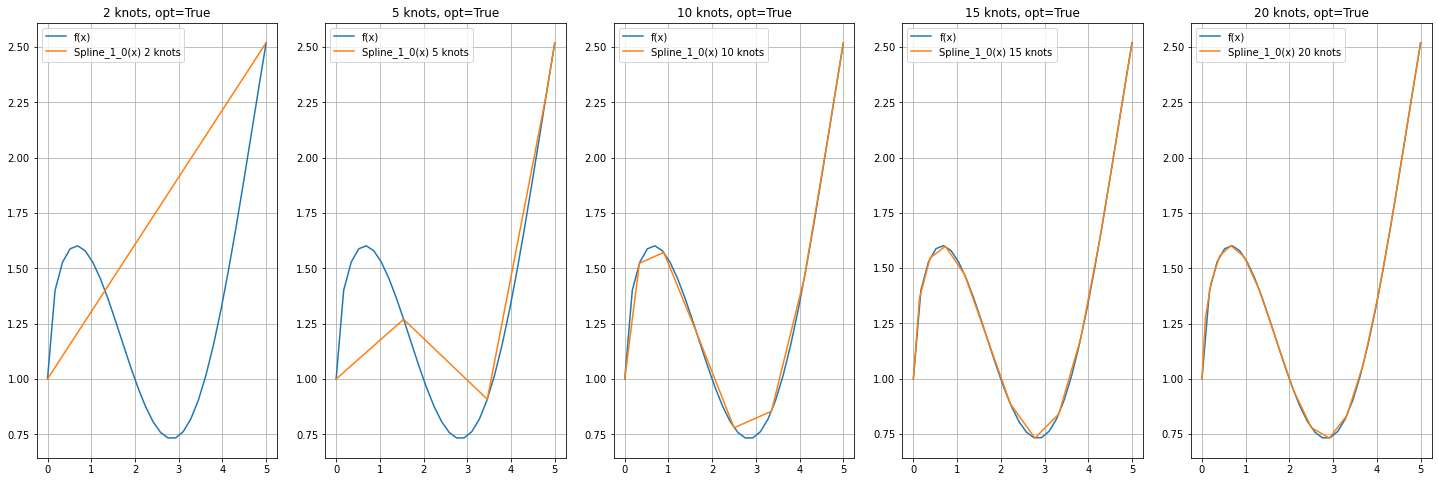

In [ ]:
NUMBER_OF_KNOTS = [2, 5, 10, 15, 20]
opt = True
m = 30
x_test = np.linspace(a, b, m)
y_true = [f(x_i) for x_i in x_test]

fig, axes = plt.subplots(1, len(NUMBER_OF_KNOTS))
fig.set_size_inches(25, 8)

# Spline_1_0

for i in range(len(NUMBER_OF_KNOTS)):
    x, y = generate_intervals(NUMBER_OF_KNOTS[i], opt=opt)
    coefficients = spline_1_0_get_coef(x, y, NUMBER_OF_KNOTS[i])

    y_predicted = [spline_1_0(coefficients, x_i) for x_i in x]
    axes[i].plot(x_test, y_true, label = "f(x)")
    axes[i].plot(x, y_predicted, label = "Spline_1_0(x) {} knots".format(NUMBER_OF_KNOTS[i]))
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title('{knots} knots, opt={opt}'.format(knots=NUMBER_OF_KNOTS[i], opt=opt))


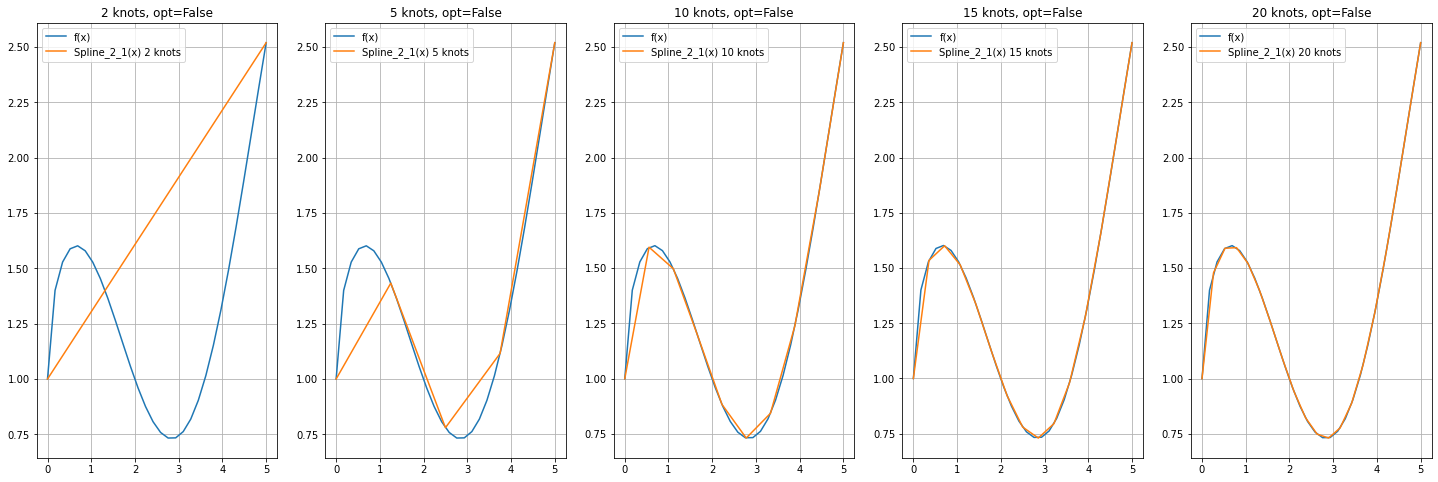

In [ ]:
NUMBER_OF_KNOTS = [2, 5, 10, 15, 20]
opt = False
m = 30
x_test = np.linspace(a, b, m)
y_true = [f(x_i) for x_i in x_test]

fig, axes = plt.subplots(1, len(NUMBER_OF_KNOTS))
fig.set_size_inches(25, 8)

# Spline_2_1

for i in range(len(NUMBER_OF_KNOTS)):
    x, y = generate_intervals(NUMBER_OF_KNOTS[i], opt=opt)
    coefficients = spline_2_1_get_coef(x, y, NUMBER_OF_KNOTS[i])

    y_predicted = [spline_2_1(coefficients, x_i) for x_i in x]
    axes[i].plot(x_test, y_true, label = "f(x)")
    axes[i].plot(x, y_predicted, label = "Spline_2_1(x) {} knots".format(NUMBER_OF_KNOTS[i]))
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title('{knots} knots, opt={opt}'.format(knots=NUMBER_OF_KNOTS[i], opt=opt))

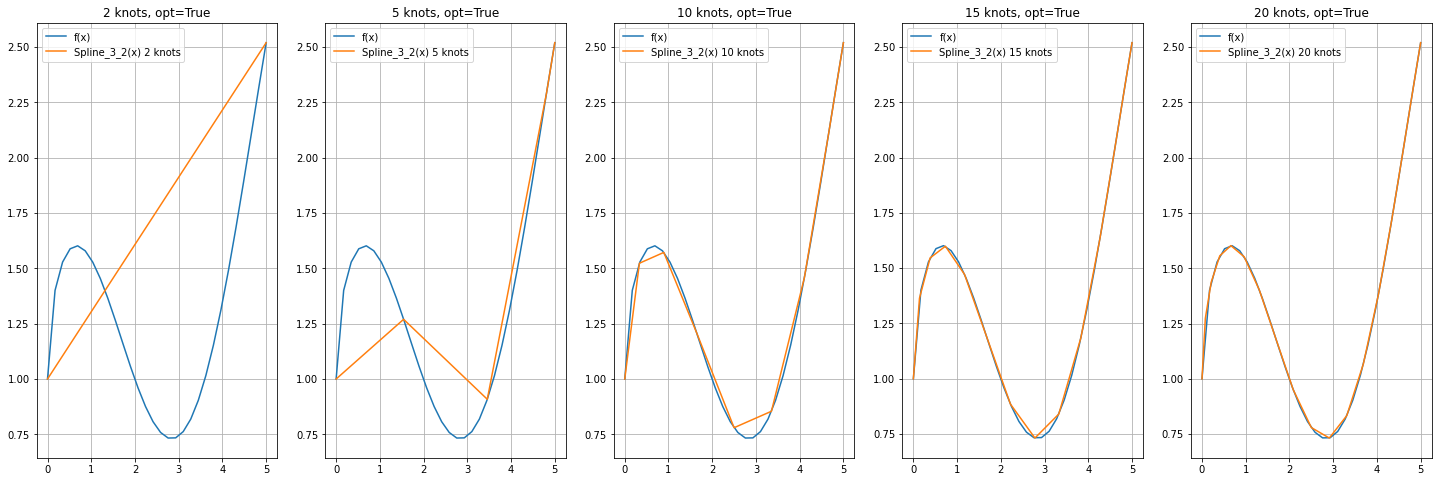

In [ ]:
NUMBER_OF_KNOTS = [2, 5, 10, 15, 20]
opt = True
m = 30
x_test = np.linspace(a, b, m)
y_true = [f(x_i) for x_i in x_test]

fig, axes = plt.subplots(1, len(NUMBER_OF_KNOTS))
fig.set_size_inches(25, 8)

#Spline_3_2

for i in range(len(NUMBER_OF_KNOTS)):
    x, y = generate_intervals(NUMBER_OF_KNOTS[i], opt=opt)
    coefficients = spline_3_2_get_coef(x, y, NUMBER_OF_KNOTS[i])

    y_predicted = [spline_3_2(coefficients, x_i) for x_i in x]
    axes[i].plot(x_test, y_true, label = "f(x)")
    axes[i].plot(x, y_predicted, label = "Spline_3_2(x) {} knots".format(NUMBER_OF_KNOTS[i]))
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title('{knots} knots, opt={opt}'.format(knots=NUMBER_OF_KNOTS[i], opt=opt))

In [ ]:
def maximum_deviation_spline_3_2(knots, opt, m):
    x_test = np.linspace(a, b, m)
    differences = []
    x, y = generate_intervals(knots, opt)
    coefficients = spline_3_2_get_coef(x, y, knots)
    for x_i in x_test:
        differences.append(abs(f(x_i) - spline_3_2(coefficients, x_i)))
    return max(differences)

In [ ]:
def maximum_deviation_spline_2_1(knots, opt, m):
    x_test = np.linspace(a, b, m)
    differences = []
    x, y = generate_intervals(knots, opt)
    coefficients = spline_2_1_get_coef(x, y, knots)
    for x_i in x_test:
        differences.append(abs(f(x_i) - spline_2_1(coefficients, x_i)))
    return max(differences)

In [ ]:
def maximum_deviation_spline_1_0(knots, opt, m):
    x_test = np.linspace(a, b, m)
    differences = []
    x, y = generate_intervals(knots, opt)
    coefficients = spline_1_0_get_coef(x, y, knots)
    for x_i in x_test:
        differences.append(abs(f(x_i) - spline_1_0(coefficients, x_i)))
    return max(differences)

In [ ]:
#Spline_3_2
deviation_spline_3_2 = []
deviation_opt_spline_3_2 = []
n = 50
m = n * 10

for i in range(2, n + 1):
    deviation_spline_3_2.append(maximum_deviation_spline_3_2(i, False, m))
    deviation_opt_spline_3_2.append(maximum_deviation_spline_3_2(i, True, m))
  
print(deviation_spline_3_2)
print(deviation_opt_spline_3_2)

[1.1826690397575128, 0.8040710644167285, 0.4494910883305734, 0.3220058124010341, 0.26441942828344, 0.22975586274140292, 0.20622091305514556, 0.18883162073778537, 0.1754028084355792, 0.1644630240574947, 0.15545017472563427, 0.1477975996680012, 0.14128788472455533, 0.1354953465410096, 0.130401623353942, 0.12582728233644724, 0.12179936516483147, 0.11792796868405286, 0.11463976790180141, 0.11160492315408255, 0.10866658378758443, 0.10581720104347303, 0.10349396058623062, 0.10131242748270908, 0.0991865366917215, 0.09711274468537745, 0.09508790574534065, 0.09310921274761141, 0.09147561815244698, 0.09003160237128882, 0.08861590105275763, 0.08722710007711698, 0.08586391036488505, 0.08452515304494579, 0.08320974681019977, 0.0819166970791827, 0.08064508665823111, 0.07939406765793855, 0.0781628544639783, 0.07708649494538866, 0.07627274725658051, 0.0754701910295994, 0.07467842444562689, 0.07389707120121192, 0.07312577830885325, 0.07236421413583405, 0.07161206665048114, 0.07086904184961917, 0.070134

In [ ]:
#Spline_2_1
deviation_spline_2_1 = []
deviation_opt_spline_2_1 = []
n = 50
m = n * 10

for i in range(2, n + 1):
    deviation_spline_2_1.append(maximum_deviation_spline_2_1(i, False, m))
    deviation_opt_spline_2_1.append(maximum_deviation_spline_2_1(i, True, m))
  
print(deviation_spline_2_1)
print(deviation_opt_spline_2_1)

[0.8334851440672899, 0.6187532427027596, 0.5746198777018845, 0.5159071334427539, 0.4672271846669527, 0.4287094262304678, 0.39790171895640536, 0.37265775710896043, 0.35163833661612043, 0.33372273149651166, 0.31830539200786845, 0.30467893442167493, 0.29286204287205475, 0.2822522137904704, 0.27268265700179506, 0.2639460363937891, 0.25607385943660566, 0.24898094878449983, 0.2421469328197361, 0.23620161337567747, 0.2302840596792357, 0.2252267024658825, 0.22005280326854915, 0.21554192220242419, 0.21127575206032656, 0.20692326116294524, 0.20309991703637453, 0.19963916989697994, 0.1961159997700701, 0.19253149835579753, 0.18939159520871707, 0.1866702101999853, 0.1839059390290667, 0.18109943880134205, 0.17825133716438946, 0.17536223446082788, 0.1733017461310935, 0.17123966034412152, 0.1691502513487415, 0.16703387242098255, 0.1648908634399806, 0.16272155171735037, 0.16052625275602006, 0.15830527094611768, 0.1568262622261729, 0.15537251781605166, 0.15390288207307812, 0.1524175251431914, 0.15091661

In [ ]:
#Spline_1_0
deviation_spline_1_0 = []
deviation_opt_spline_1_0 = []
n = 50
m = n * 10

for i in range(2, n + 1):
    deviation_spline_1_0.append(maximum_deviation_spline_1_0(i, False, m))
    deviation_opt_spline_1_0.append(maximum_deviation_spline_1_0(i, True, m))
  
print(deviation_spline_1_0)
print(deviation_opt_spline_1_0)

[1.1826690397575128, 0.6638242207479443, 0.5301070929997813, 0.41563343497425764, 0.34220234863144783, 0.293750298226374, 0.2599212757066893, 0.23502633769544445, 0.21588385991523795, 0.20067617521178516, 0.18833517549763035, 0.17795093504937576, 0.16913762213056938, 0.16156481458792604, 0.15493139769946773, 0.14894317303935267, 0.14381008184275612, 0.13897868415482661, 0.1348285511470042, 0.13082268730955948, 0.12730120909240017, 0.12408082261275544, 0.12095317682536355, 0.11801187078602338, 0.11554187640790126, 0.11313245233985536, 0.11077930842811123, 0.10847863290667004, 0.10631802563738235, 0.10455354580212628, 0.10282367391031277, 0.10112641905265152, 0.09945997359737024, 0.09782269062198568, 0.09621306475883284, 0.09462971585030533, 0.09318240708781733, 0.09203153000027076, 0.09089772061671475, 0.08978022771356464, 0.08867835379134448, 0.08759144986140366, 0.08651891086184738, 0.0854601716128951, 0.08441470323653455, 0.08338200997732725, 0.08236162637106426, 0.08135311471609197,

In [ ]:
import pandas as pd

#Spline_1_0
knots = list(range(2, n + 1))
test_points = [m] * (n * 10)

df_spline_1_0 = pd.DataFrame(list(zip(knots, test_points, deviation_spline_1_0, deviation_opt_spline_1_0)), 
                  columns=['Количество узлов', 'Количество проверочных точек', 'Максимальное отклонение RS', 'Максимальное отклонение RSopt '])
df_spline_1_0

,Количество узлов,Количество проверочных точек,Максимальное отклонение RS,Максимальное отклонение RSopt
0,2,500,1.182669,1.182669
1,3,500,0.663824,0.704823
2,4,500,0.530107,0.663824
3,5,500,0.415633,0.498171
4,6,500,0.342202,0.351157
5,7,500,0.293750,0.264975
6,8,500,0.259921,0.213143
7,9,500,0.235026,0.179252
8,10,500,0.215884,0.155376
9,11,500,0.200676,0.137510


In [ ]:
#Spline_2_1
knots = list(range(2, n + 1))
test_points = [m] * (n * 10)

df_spline_2_1 = pd.DataFrame(list(zip(knots, test_points, deviation_spline_2_1, deviation_opt_spline_2_1)), 
                  columns=['Количество узлов', 'Количество проверочных точек', 'Максимальное отклонение RS', 'Максимальное отклонение RSopt '])
df_spline_2_1

,Количество узлов,Количество проверочных точек,Максимальное отклонение RS,Максимальное отклонение RSopt
0,2,500,0.833485,0.833485
1,3,500,0.618753,0.587894
2,4,500,0.574620,0.618753
3,5,500,0.515907,0.570018
4,6,500,0.467227,0.641184
5,7,500,0.428709,0.602632
6,8,500,0.397902,0.564068
7,9,500,0.372658,0.569804
8,10,500,0.351638,0.573089
9,11,500,0.333723,0.578875


In [ ]:
#Spline_3_2
knots = list(range(2, n + 1))
test_points = [m] * (n * 10)

df_spline_3_2 = pd.DataFrame(list(zip(knots, test_points, deviation_spline_3_2, deviation_opt_spline_3_2)), 
                  columns=['Количество узлов', 'Количество проверочных точек', 'Максимальное отклонение RS', 'Максимальное отклонение RSopt '])
df_spline_3_2

,Количество узлов,Количество проверочных точек,Максимальное отклонение RS,Максимальное отклонение RSopt
0,2,500,1.182669,1.182669
1,3,500,0.804071,0.824715
2,4,500,0.449491,0.756619
3,5,500,0.322006,0.419196
4,6,500,0.264419,0.277748
5,7,500,0.229756,0.214952
6,8,500,0.206221,0.178115
7,9,500,0.188832,0.153004
8,10,500,0.175403,0.134522
9,11,500,0.164463,0.120209
